# README

Aim:
- For a set of 6 *Klebsiella* samples
- With treatment conditions of *pooled sera* and *media*
- In each set, 
    - filter by adjusted p value / false discovery rate of <= 0.05
    - find genes up or downregulated across these conditions with a log2 fold change of >= 1 or <= -1
- Find which of these genes *intersect* across all 6 strains

Aim is to get a transcriptome Venn diagram showing the overlap in the middle of the 6 Kp isolates for the number of genes that are upregulated >2X.
- check id uniqueness
- K. pneumo strain comparisons of media vs sera
- Filter between >= log1 or <= log-1
- remap

Important notes:
- There are 2 *Klebsiella pneumoniae* strains and 4 *Klebsiella variicola* strains.
- Genes are based on annotations in gtf and gff files, many of which do not have annotated gene names. In these cases, they were replaced with the unique database identifiers. Annotation gtf and gff files are attached for reference.
- The annotation files were obtained from NCBI.
- The data used is identical to the **transcriptome** data shown by the earlier DEG reports.


Strain information:

- *Klebsiella pneumoniae*:
    - AJ218
    - KPC2

- *Klebsiella variicola*:
    - 03-311-0071
    - 04153260899A
    - AJ055
    - AJ292

Software:
```
matplotlib 3.2.1
numpy 1.18.4
pandas 1.0.3
python 3.8.2
upsetplot 0.3.0.post3
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from upsetplot import from_contents, from_memberships, plot, generate_counts, UpSet
%matplotlib inline

Load the data. Files are identical to those shown in the original DEG reports.

In [2]:
infile_aj218 = "".join([
    "20190514_Analysed_data_Kpneumoniae_Transcriptomics_BPA_Sepsis_Monash_20190514/",
    "Kpneumoniae_AJ218_Pooled_sera_RPMI_SEP_Monash_20190514/",
    "gene_expression_analysis/",
    "Kpneumoniae_AJ218_DEG_Pooled_sera_vs_RPMI_cpmfilterminprop0.75_20190514.txt",
])
infile_kpc2 = "".join([
    "20190514_Analysed_data_Kpneumoniae_Transcriptomics_BPA_Sepsis_Monash_20190514/",
    "Kpneumoniae_KPC2_Pooled_sera_RPMI_SEP_Monash_20190514/",
    "gene_expression_analysis/",
    "Kpneumoniae_KPC2_DEG_Pooled_sera_vs_RPMI_cpmfilterminprop0.75_20190514.txt"
])
infile_033110071 = "".join([
    "20190514_Analysed_data_Kvariicola_Transcriptomics_BPA_Sepsis_Monash_20190514/",
    "Kvariicola_03-311-0071_Transcriptomics_BPA_Sepsis_Monash_20190514/",
    "gene_expression_analysis/",
    "Kvariicola_03-311-0071_DEG_Pooled_sera_vs_RPMI_cpmfilterminprop0.75_20190514.txt"
])
infile_04153260899 = "".join([
    "20190514_Analysed_data_Kvariicola_Transcriptomics_BPA_Sepsis_Monash_20190514/",
    "Kvariicola_04153260899A_Transcriptomics_BPA_Sepsis_Monash_20190514/",
    "gene_expression_analysis/",
    "Kvariicola_04153260899A_DEG_Pooled_sera_vs_RPMI_cpmfilterminprop0.75_20190514.txt"    
])
infile_aj055 = "".join([
    "20190514_Analysed_data_Kvariicola_Transcriptomics_BPA_Sepsis_Monash_20190514/",
    "Kvariicola_AJ055_Transcriptomics_BPA_Sepsis_Monash_20190514/",
    "gene_expression_analysis/",
    "Kvariicola_AJ055_DEG_Pooled_sera_vs_RPMI_cpmfilterminprop0.75_20190514.txt"
])
infile_aj292 = "".join([
    "20190514_Analysed_data_Kvariicola_Transcriptomics_BPA_Sepsis_Monash_20190514/",
    "Kvariicola_AJ292_Transcriptomics_BPA_Sepsis_Monash_20190514/",
    "gene_expression_analysis/",
    "Kvariicola_AJ292_DEG_Pooled_sera_vs_RPMI_cpmfilterminprop0.75_20190514.txt"
])
infile_paths = [
    infile_aj218, infile_kpc2, infile_033110071, infile_04153260899, infile_aj055, infile_aj292
]

Load the annotations. Files are identical to those shown used in the original DEG mappings.

In [3]:
infile_aj218_gtf = "GCF_900622605.1_AJ218_genomic.gtf"
infile_kpc2_gtf = "GCF_900622645.1_KPC2_genomic.gtf"
infile_033110071_gtf = "GCF_900622625.1_03-311-0071_genomic.gtf"
infile_04153260899A_gtf = "GCF_900622615.1_04153260899A_genomic.gtf"
infile_aj055_gtf = "GCF_900622585.1_AJ055_genomic.gtf"
infile_aj292_gtf = "GCF_900622595.1_AJ292_genomic.gtf"
infile_gtf = [
    infile_aj218_gtf, 
    infile_kpc2_gtf, 
    infile_033110071_gtf, 
    infile_04153260899A_gtf,
    infile_aj055_gtf,
    infile_aj292_gtf
]

In [4]:
def filter_log(data, l_bound=-1, u_bound=1, col="logFC"):
    """Get values for col which fall outside ranges"""
    low = data[(data[col] <= l_bound)]
    high = data[(data[col] > u_bound)]
    return pd.concat([low, high])

def filter_fdr(data, fdr="adj.P.Val"):
    """Get values for FDR which are less than 0.05"""
    return data[data[fdr] <= 0.05]

Get a list of genes in each comparison (pooled sera vs media) with a fold change (positive or negative).

In [5]:
mapping = [pd.read_csv(x, sep="\t", index_col=0, header=None) for x in infile_gtf]

data = [pd.read_csv(x, sep="\t", index_col=0)[["logFC", "adj.P.Val"]] for x in infile_paths]
fdr = [filter_fdr(x) for x in data]
logfc = [filter_log(x) for x in fdr]
indices = [x.index.to_list() for x in logfc]

strains = ["_".join(x.split("/")[-1].split("_")[0:2]) for x in infile_paths]
str_ind = dict(zip(strains, indices))

Of the six gene lists, perform an intersection. We visualise this information with a quantitative venn diagram.

(5435, 1)

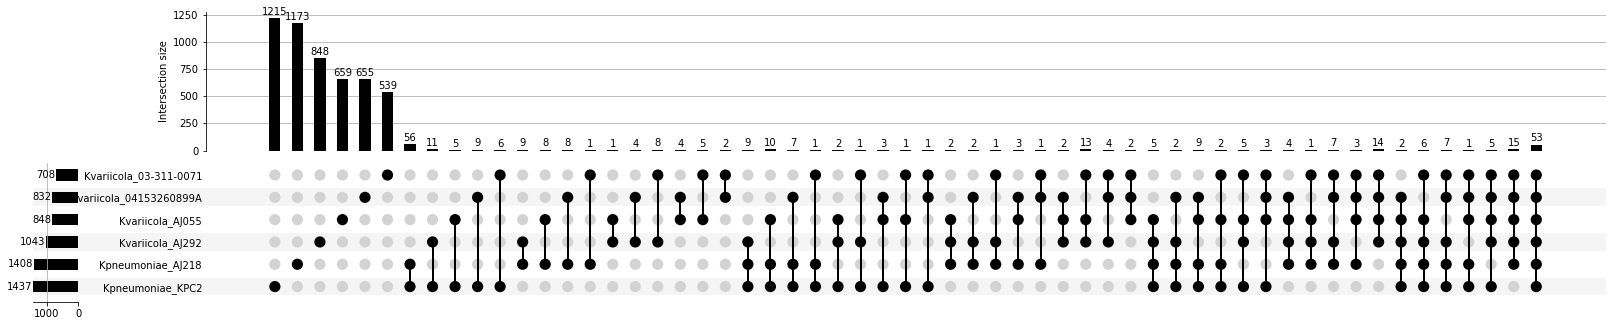

In [6]:
upset_data = from_contents(str_ind)
plot(upset_data, subset_size="count", show_counts=True)
upset_data.shape

In [7]:
intersect_all = upset_data.loc[True].loc[True].loc[True].loc[True].loc[True].reset_index(drop=True)
intersect_all.to_csv("intersect_all.tsv", sep="\t", index=False, header=False)
intersect_all

id
0   cpxP
1   csiD
2   lldR
3   xylB
4   betB
5   nhaA
6   betA
7   aldA
8   yccA
9   creD
10  rihA
11  betI
12  cirA
13  carA
14  sgrT
15  osmB
16  iolD
17  hutH
18  iolC
19  mmsA
20  hutU
21  lsrA
22  iolB
23  lsrC
24  hypE
25  nuoB
26  hycI
27  hypD
28  ydfZ
29  hycH
30  lsrB
31  frdD
32  frdC
33  lsrR
34  iolE
35  nrdD
36  hycD
37  mntS
38  uspG
39  dhaM
40  dhaL
41  lsrG
42  dhaK
43  glgA
44  glgC
45  yedE
46  ftsB
47  gudD
48  glgX
49  hycA
50  araC
51  malG
52  glpK
53  garL